# Class 3
# Lesson 02

## Problem:
Build a machine learning algorithm that distinguishes between "bad" connections (called intrusions or attacks) and "good" (normal) connections. The number of normal connections is greater than that of bad ones.

## Original dataset:
http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

## Instructions:
1. [Read data](#read)
2. [Build a classifier](#build)
    - [Explore the data](#explore)
    - [Clean up the data](#clean)
        - [Drop constant columns](#drop)
        - [One-hot encode categorical columns](#one-hot)
        - [Z-normalize all features](#z-normalize)
    - [Logistic regression classifier](#logit)
        - [Split the dataset 80/20 into train X, test XX, label train Y, label test YY](#split)
        - [Instantiate classifier class object](#instantiate)
        - [Train](#train)
        - [Get predictions](#predict)
        - [Create a dataframe of predicted and actual values](#actual-vs-predicted)
        - [Evaluate results](#evaluate)
        - [ROC analysis](#roc)
        - [Adjust cutoff value](#threshold)
3. [Determine your model accuracy](#accuracy)
4. [Modify data by handling class imbalance](#rebalance)
5. [Use the same model on updated data](#retrain)
6. [What is the accuracy?](#new_accuracy)
7. [Describe your findings](#findings)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 1. Read data<a id='read'></a>

In [2]:
url = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Intrusion%20Detection.csv'
local_path = './Intrusion Detection.csv'

print('Trying to load the data set from a local file if it exists...')
try:
    conn_df = pd.read_csv(local_path)
except FileNotFoundError:
    print('\tFile not found, loading from Internet...')
    conn_df = pd.read_csv(url)
    print('\t\tData loaded from url')
else:
    print('\tData loaded from local file')

Trying to load the data set from a local file if it exists...
	Data loaded from local file


# 2. Build a classifier<a id='build'></a>

## Explore the data<a id='explore'></a>

In [3]:
conn_df.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
97303,321,tcp,telnet,RSTO,1506,1887,0,0,0,0,...,6,1.0,0.0,0.17,0.0,0.0,0.0,0.17,0.17,1
97304,45,tcp,telnet,SF,2336,4201,0,0,0,3,...,7,1.0,0.0,0.14,0.0,0.0,0.0,0.14,0.14,1
97305,176,tcp,telnet,SF,1559,2732,0,0,0,3,...,8,1.0,0.0,0.12,0.0,0.0,0.0,0.12,0.12,1
97306,61,tcp,telnet,SF,2336,4194,0,0,0,3,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.11,0.11,1
97307,47,tcp,telnet,SF,2402,3816,0,0,0,3,...,10,1.0,0.0,0.10,0.0,0.0,0.0,0.10,0.10,1


In [4]:
conn_df.isnull().any().sum()

0

In [5]:
# Data set size, data types and number of unique values in each column
def dtypes_unique(df):
    """Return a df of dtypes and numbers of unique values in the df for pretty printing."""
    dtypes_unique_vals = pd.DataFrame({'dtypes': df.dtypes})  
    unique_vals = []
    for var in df.columns:
        unique_vals.append(len(df.loc[:, var].unique()))
    # Add the number of unique values to this dataframe
    dtypes_unique_vals['unique_vals'] = unique_vals
    
    return dtypes_unique_vals

print(conn_df.shape)
print(dtypes_unique(conn_df))

(97308, 42)
                              dtypes  unique_vals
duration                       int64         2356
protocol_type                 object            3
service                       object           25
flag                          object            9
src_bytes                      int64         3250
dst_bytes                      int64        10694
land                           int64            2
wrong_fragment                 int64            1
urgent                         int64            2
hot                            int64           19
num_failed_logins              int64            5
logged_in                      int64            2
num_compromised                int64           20
root_shell                     int64            2
su_attempted                   int64            3
num_root                       int64           15
num_file_creations             int64           17
num_shells                     int64            2
num_access_files               int64  

In [6]:
np.round(conn_df.describe())

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
count,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,...,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0,97308.0
mean,217.0,1157.0,3386.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,202.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1359.0,34221.0,37573.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,...,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,147.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,170.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,231.0,421.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,313.0,2124.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,58329.0,2194619.0,5134218.0,1.0,0.0,3.0,30.0,4.0,1.0,884.0,...,255.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
# Correlation coefficients to see if there are any particular 
# features predicting the target label well
corr = conn_df.corr()['connection_type']
corr[corr > 0.01]

hot                            0.041305
logged_in                      0.010977
root_shell                     0.513066
num_file_creations             0.054110
serror_rate                    0.040070
dst_host_same_src_port_rate    0.034157
dst_host_srv_diff_host_rate    0.017985
connection_type                1.000000
Name: connection_type, dtype: float64

In [8]:
print('cases with connection type 0:', len(conn_df[conn_df['connection_type'] == 0]))
print('cases with connection type 1:', len(conn_df[conn_df['connection_type'] == 1]))

cases with connection type 0: 97278
cases with connection type 1: 30


The target class label is 'connection_type', with 0 for normal connections and 1 for bad connections.

## Clean up the data<a id='clean'></a>

### Drop constant columns<a id='drop'></a>

In [9]:
constant_features = ['wrong_fragment', 'num_outbound_cmds', 'is_host_login']  # To drop
conn_df_reduced = conn_df.drop(constant_features, axis = 1)
print(conn_df_reduced.shape)

(97308, 39)


### One-hot encode categorical columns<a id='one-hot'></a>

In [10]:
categorical_features = ['protocol_type', 'service', 'flag']  # To one-hot encode
conn_df_cleaned = pd.get_dummies(conn_df_reduced,
                                 columns=categorical_features)
print('\nResulting dataset: {} observations, {} attributes'
      .format(conn_df_cleaned.shape[0], conn_df_cleaned.shape[1]))


Resulting dataset: 97308 observations, 73 attributes


###  Z-normalize all features<a id='z-normalize'></a>

In [11]:
feature_names = conn_df_cleaned.columns.tolist()  # List of features
feature_names.remove('connection_type')  # Omit target variable
# Use preprocessing.StandardScaler() to z-normalize
for cat in feature_names:
    column = conn_df_cleaned[[cat]].astype(float)
    conn_df_cleaned[cat] = preprocessing.StandardScaler().fit_transform(column)

## Logistic regression classifier<a id='logit'></a>

### Split the dataset 80/20 into train X, test XX, label train Y, label test YY<a id='split'></a>

In [12]:
y_conn = conn_df_cleaned.loc[:, 'connection_type'].values.astype(str)
x_conn = conn_df_cleaned.drop('connection_type', axis=1)
X, XX, Y, YY = train_test_split(x_conn,
                                y_conn,
                                train_size = 0.8,
                                test_size = 0.2,
                                random_state = 0)

### Instantiate classifier class object<a id='instantiate'></a>

In [13]:
logit_clf = LogisticRegression(solver = 'lbfgs', max_iter = 150)

### Train<a id='train'></a>

In [14]:
# Use the fit() method to train the model on the training set
logit_clf.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Get predictions<a id='predict'></a>

In [15]:
# Probability threshold: a cutoff value to classify cases
PROB_TH = 0.2

def get_predicted_test_labels(model_instance, test_XX, prob_threshold = 0.5):
    """Return predicted labels for the test data."""
    # Use predict_proba method to guess labels for the test set
    YY = (model_instance.predict_proba(test_XX.values)[:, 1] >= prob_threshold)
    YY = YY.astype(int).astype(str)  # Turn booleans into "0s" and "1s"
    return YY

logit_predicted_YY = get_predicted_test_labels(logit_clf, XX, PROB_TH)

### Create a dataframe of predicted and actual values<a id='actual-vs-predicted'></a>

In [16]:
# Create dataframe of predicted and actual values
labels_dict = {'Predicted': logit_predicted_YY.astype(int), 
               'Actual': YY.astype(int)
              }
predicted_vs_actuals_df = pd.DataFrame(labels_dict)

### Evaluate results<a id='evaluate'></a>

In [17]:
def print_metrics(conf_matrix):
    """Calculate and print metics from the input confusion matrix."""
    true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()
    accuracy = (true_neg + true_pos) / sum(sum(conf_matrix))
    recall = true_pos / (true_pos + false_neg)
    specificity = true_neg / (true_neg + false_pos)
    FPR = false_pos / (false_pos + true_neg)
    precision = true_pos / (true_pos + false_pos)
    f1 = 2/((1/recall) + (1/precision))
    print_string = """Confusion matrix:
    Actual labels
    Good\tBad connections
    {} < Predicted labels
    \nMetrics:
    Accuracy (total correct predictions): {:.4f}
    Specificity (correctly labeled good connections): {:.4f}
    Recall (correctly labeled bad connections): {:.4f}
    False Positive Rate (false alarms): {:.4f}
    F1 score: : {:.4f}
    """
    print(print_string.format(conf_matrix.T, accuracy, specificity, recall, FPR, f1))

In [18]:
# Get a confusion matrix and print metrics
conf_matrix = metrics.confusion_matrix(predicted_vs_actuals_df.loc[:, "Actual"],
                                       predicted_vs_actuals_df.loc[:, "Predicted"])
print_metrics(conf_matrix)

Confusion matrix:
    Actual labels
    Good	Bad connections
    [[19453     1]
 [    0     8]] < Predicted labels
    
Metrics:
    Accuracy (total correct predictions): 0.9999
    Specificity (correctly labeled good connections): 1.0000
    Recall (correctly labeled bad connections): 0.8889
    False Positive Rate (false alarms): 0.0000
    F1 score: : 0.9412
    


In [19]:
# A combined report from metrics module
print(metrics.classification_report(predicted_vs_actuals_df.loc[:, "Actual"],
                                    predicted_vs_actuals_df.loc[:, "Predicted"],
                                    target_names=['Good connections', 'Bad connections']))

                  precision    recall  f1-score   support

Good connections       1.00      1.00      1.00     19453
 Bad connections       1.00      0.89      0.94         9

       micro avg       1.00      1.00      1.00     19462
       macro avg       1.00      0.94      0.97     19462
    weighted avg       1.00      1.00      1.00     19462



In [20]:
def print_heatmap(conf_matrix, title, labels):
    """Print a confusion matrix as a heat map, with labels from a list."""
    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Actual labels')
    plt.ylabel('Predicted labels')
    plt.title(title)
    plt.show()

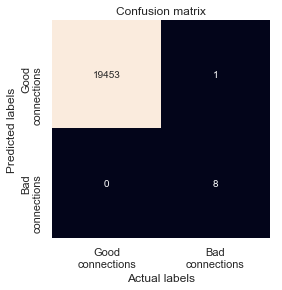

In [21]:
print_heatmap(conf_matrix.T, 'Confusion matrix', ['Good\nconnections', 'Bad\nconnections'])

### ROC analysis<a id='roc'></a>

In [22]:
def do_roc_analysis(XX, YY, model, plot = True):
    """Return area under curve metric and prob. estimates; plot ROC curve."""
    # y = probability estimates of the positive class
    #  [:,1] for predicted probabilities for the positive label only
    y = model.predict_proba(XX.values)[:, 1]
    LW = 1.5  # line width for plots
    LL = "lower right"  # legend location
    LC = "darkgreen"  # Line Color
    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = metrics.roc_curve(YY.astype(int), y)
    print('First 10 prob.thresholds:', np.round(th[:10], 3))
    AUC = metrics.auc(fpr, tpr)

    if plot:
        plt.figure()
        plt.title('ROC curve for Connections Dataset, {} Model'.format(type(model)))
        plt.xlim([-0.1, 1.0])
        plt.ylim([-0.1, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC, lw=LW,
                 label='ROC curve (area = %0.2f)' % AUC)
        plt.plot(fpr, tpr, 'bo',
                 label='ROC curve (area = %0.2f)' % AUC, alpha = 0.2)
        # reference line for random classifier
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--')
        plt.legend(loc=LL)
        plt.show()

    return AUC, y


ROC ANALYSIS
First 10 prob.thresholds: [2.    1.    0.215 0.042 0.028 0.    0.    0.    0.    0.   ]


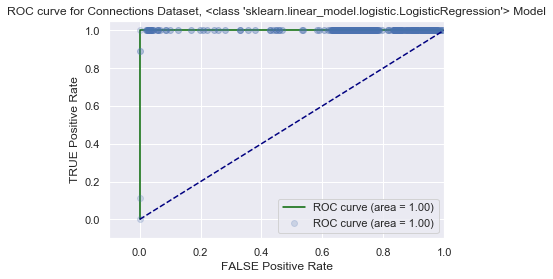

In [23]:
print("\nROC ANALYSIS")
_, _ = do_roc_analysis(XX, YY, logit_clf)

This curve does not look right because I expected the data points to be along the y-axes (since the False Positive Rate should be always near zero (the model almost always gets right all normal connections, i.e. there are no false alarms). The problem is with the metrics.roc_curve() which produces the following sequence of thresholds (I show the first 10): 2.,1.,0.215,0.042,0.028,0.,0.,0.,0.,0... As you can see, ignoring 2, it starts at 1, then plummets to nearly zero. 

In the following cell I try to change that behavior by constructing my own thresholds from 0 to 1 with intervals of 0.01. Now the datapoints in the curve are where I would have expected them to be.

But, anyway, ROC/AUC analysis does not seem to be a great help in choosing an appropriate probability threshold for identifying rare cases.

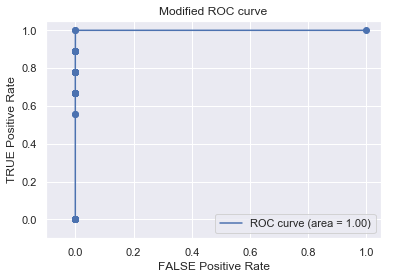

In [24]:
def build_roc(model, XX, YY, plot = True):
    """Build and print a ROC curve without using metrics.roc_curve()."""
    y = model.predict_proba(XX.values)[:, 1]
    FPR, TPR = [], []
    th = 0.0
    while th <= 1.1:
        predicted_YY = get_predicted_test_labels(model, XX, th)
        labels_dict = {'Predicted': predicted_YY.astype(int),
                       'Actual': YY.astype(int)
                      }
        predicted_vs_actuals_df = pd.DataFrame(labels_dict)
        conf_matrix = metrics.confusion_matrix(predicted_vs_actuals_df.loc[:, "Actual"],
                                               predicted_vs_actuals_df.loc[:, "Predicted"]
                                              )
        true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()
        FPR.append(false_pos / (true_neg + false_pos)) 
        TPR.append(true_pos / (true_pos + false_neg))
        th += 0.01
    AUC = metrics.auc(FPR, TPR) 
    if plot:
        plt.figure()
        plt.title('Modified ROC curve')
        plt.xlim([-0.1, 1.05])
        plt.ylim([-0.1, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot(FPR, TPR, 'bo')
        plt.legend(loc='lower right')
        plt.show()
    
build_roc(logit_clf, XX, YY)

### Adjust cutoff value<a id='threshold'></a>

By trial, I set the probability threshold at 0.2. This allows the model to predict most bad connections correctly.

# 3. Determine your model accuracy<a id='accuracy'></a>

I used scikit-learn's Logistic Regression model. I tried different solvers and threshold values to achieve the maximum recall rate (i.e. ability to predict the rare class). The model's recall on the test dataset is 0.89. One bad connection case was misclassified as a good connection. Its False Positive Rate (i.e. false alarms) is 0. 

# 4. Modify data by handling class imbalance<a id='rebalance'></a>

In [25]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

In [26]:
print('Original train dataset shape {}'.format(Counter(Y)))
print('Original test dataset shape {}'.format(Counter(YY)))

Original train dataset shape Counter({'0': 77825, '1': 21})
Original test dataset shape Counter({'0': 19453, '1': 9})


In [27]:
# Re-sample training data
sm = SMOTE(random_state=42)
X_resample, Y_resample = sm.fit_sample(X, Y)
print('Resampled train dataset shape {}'.format(Counter(Y_resample)))

Resampled train dataset shape Counter({'0': 77825, '1': 77825})


# 5. Use the same model on updated data<a id='retrain'></a>

In [28]:
# Instantiate the classifier class object. Note: the solver is different
logit_clf_resample = LogisticRegression(solver = 'liblinear')
# Train on re-sampled training dataset
logit_clf_resample.fit(X_resample, Y_resample)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
# Set the probability threshold for classifying cases
PROB_TH = 0.2
# Get predictions for the testing cases
logit_predicted_YY_resample = get_predicted_test_labels(logit_clf_resample, XX, PROB_TH)

# 6. What is the accuracy?<a id='new_accuracy'></a>

In [30]:
# Create a datframe of predicted and actual values
labels_dict_resample = {'Predicted': logit_predicted_YY_resample.astype(int),
                        'Actual': YY.astype(int)
                       }
predicted_vs_actuals_df_resample = pd.DataFrame(labels_dict_resample)

In [31]:
# Set up a confusion matrix
conf_matrix_resample = metrics.confusion_matrix(predicted_vs_actuals_df_resample.loc[:, "Actual"],
                                       predicted_vs_actuals_df_resample.loc[:, "Predicted"])
# Print metrics
print_metrics(conf_matrix_resample)

Confusion matrix:
    Actual labels
    Good	Bad connections
    [[19433     0]
 [   20     9]] < Predicted labels
    
Metrics:
    Accuracy (total correct predictions): 0.9990
    Specificity (correctly labeled good connections): 0.9990
    Recall (correctly labeled bad connections): 1.0000
    False Positive Rate (false alarms): 0.0010
    F1 score: : 0.4737
    


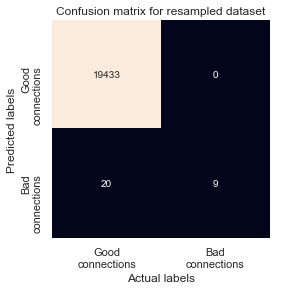

In [32]:
print_heatmap(conf_matrix_resample.T,
              'Confusion matrix for resampled dataset', 
              ['Good\nconnections', 'Bad\nconnections']
             )


ROC ANALYSIS
First 10 prob.thresholds: [2.    1.    0.998 0.021 0.02  0.015 0.015 0.003 0.003 0.003]


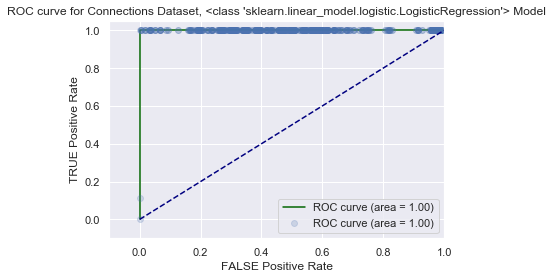

In [33]:
print("\nROC ANALYSIS")
_, _ = do_roc_analysis(XX, YY, logit_clf_resample)

The ROC/AUC analysis does not look helpful. Additional comments are in the [ROC analysis](#roc) section above. 

The accuracy of the model trained on the re-sampled data has improved. Its recall rate for the bad connections is 100%, with the false alarms rate (False Positive Rate) being 0.001. In absolute terms, the model correctly predicted all 9 bad connection cases and misclassified 20 good connections out of 19,453 as bad ones.

# 7. Describe your findings<a id='findings'></a>

I used scikit-learn's Logistic Regression model to predict bad connections. 

By trying out different model solvers and probability thresholds, I achieved the recall rate (i.e. ability to predict the rare class) for the test dataset of 0.89. The model's False Positive Rate (i.e. false alarms rate) was 0. In absolute terms, one bad connection case was misclassified as a good connection, while all good connections were classified correctly.

After applying a re-sampling technique to handle the data imbalance in the dataset and trying out different model solvers and probability thresholds, I achieved a 100% recall rate. At the same time, the model produced 20 false alarms by misclassifying 20 good connections out of 19,453 as bad ones.

I believe that the re-sampling of the training data improved the model by reducing the amount of missed bad connections to 0. I consider a slight increase in false alarms to be negligible.